# Improve embedding with HuggingFace pre-trained models

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Imports

In [ ]:
#classic
import pandas as pd
import numpy as np
from datetime import datetime


#visualization
import matplotlib.pyplot as plt

#models
from transformers import AutoTokenizer, TFAutoModel

import tensorflow as tf

## 2. Data

In [3]:
df = pd.read_pickle('/content/drive/MyDrive/raw_data/data_movie.pkl')

In [4]:
df.head()

,user_id,movie_id,rating,movie_title,plot_synopsis
0,186,302,3,L.A. Confidential,"An opening montage, narrated by Sid Hudgens (D..."
1,244,51,2,Legends of the Fall,Sick of betrayals the United States government...
2,166,346,1,Jackie Brown,"Los Angeles,1995. Jackie Brown (Pam Grier) is ..."
3,298,474,4,Dr. Strangelove or: How I Learned to Stop Worr...,At the Burpelson U.S. Air Force Base somewhere...
4,305,451,3,Grease,"In 1958, during their summer vacation, Danny Z..."


In [5]:
df.shape

(74230, 5)

## 3. Visualization

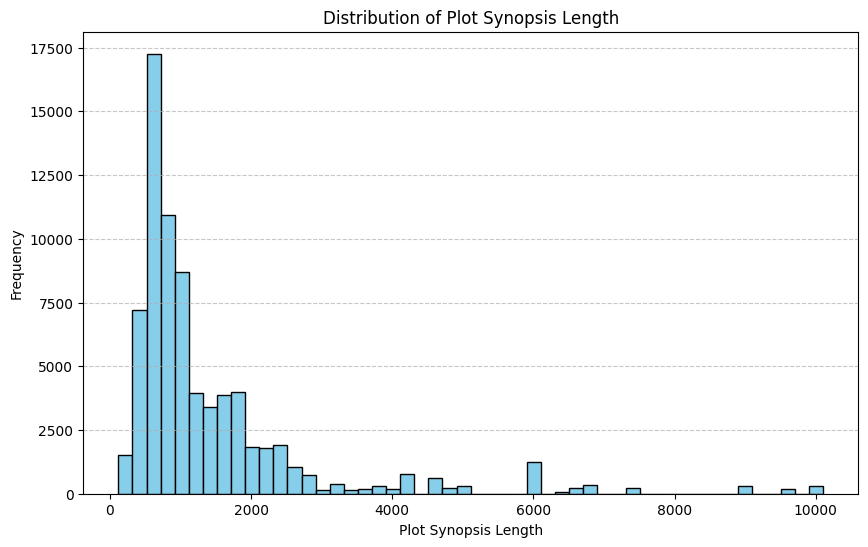

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(df['plot_synopsis'].apply(lambda x: len(x.split())), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Plot Synopsis Length')
plt.xlabel('Plot Synopsis Length')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [7]:
# cutting plot synopsis > 2000
df['plot_word_count'] = df['plot_synopsis'].apply(lambda x: len(x.split()))
df_2000 = df[df['plot_word_count'] < 2000].copy()
df_2000 = df_2000.drop(columns = 'plot_word_count', axis = 1)

In [8]:
df_2000.shape

(61370, 5)

## 4. Using pre-trained models

### 1. Text embedding with bert

In [9]:
model_name = "prajjwal1/bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModel.from_pretrained(model_name, from_pt = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'bert.embeddings.position_ids', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are 

In [10]:

# too heavy, try it below with just 2000 rows

# movie_titles = df_2000['movie_title'].tolist()
# plot_synopses = df_2000['plot_synopsis'].tolist()


# # Tokenize the text data
# token_tensor = tokenizer(movie_titles, plot_synopses, padding=True, max_length= 500, truncation=True, return_tensors="tf")

# # Create input tensors
# input_tensor = token_tensor['input_ids']

# # Generate embeddings
# prediction = model.predict(input_tensor)

# prediction

In [11]:
#embeddings = prediction.last_hidden_state[:, 0, :].numpy()

In [12]:
df_small = df_2000.head(2000)

In [13]:
df_small.shape

(2000, 5)

In [ ]:
movie_titles = df_small['movie_title'].tolist()
plot_synopses = df_small['plot_synopsis'].tolist()


# Tokenize the text data
token_tensor = tokenizer(movie_titles, plot_synopses, padding=True, max_length= 500, truncation=True, return_tensors="tf")

# Create input tensors
input_tensor = token_tensor['input_ids']

# Generate embeddings
prediction = model.predict(input_tensor)


In [ ]:
prediction

In [18]:
# Process the embeddings as np
embeddings = prediction.last_hidden_state[:, 0, :]

**Movie similarity with cosinus similarity**

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity between embeddings
similarity_matrix = cosine_similarity(embeddings)

# Example: Get top 10 most similar movies for each movie
num_movies = similarity_matrix.shape[0]
top_n = 1  # Number of similar movies to retrieve

for i in range(num_movies):
    # Sort similarity scores for movie i
    sim_scores = sorted(enumerate(similarity_matrix[i]), key=lambda x: x[1], reverse=True)
    # Exclude movie i itself
    sim_scores = sim_scores[1:]
    # Get indices of top similar movies
    top_indices = [idx for idx, _ in sim_scores[:top_n]]
    # Print movie titles of top similar movies
    print(f"Top {top_n} similar movies for '{movie_titles[i]}':")
    for idx in top_indices:
        print(f"  - {movie_titles[idx]}")
    print()

**Movie recommendation with cosine similarity**

In [32]:
# Calculate Movie Similarity

similarity_matrix = cosine_similarity(embeddings)

# Select User Preferences
user_input = input("Enter a movie title you like: ")

# Retrieve Similar Movies
movie_idx = movie_titles.index(user_input)
sim_scores = list(enumerate(similarity_matrix[movie_idx]))
sim_scores_sorted = sorted(sim_scores, key=lambda x: x[1], reverse=True)

# Filter Recommendations (optional)
top_n = 5  # Number of recommendations to display
recommended_movies = [movie_titles[idx] for idx, _ in sim_scores_sorted[1:top_n+1]]  # Exclude the input movie itself

# Display Recommendations
print(f"Recommended movies based on '{user_input}':")
for movie in recommended_movies:
    print(movie)

Enter a movie title you like: Batman


ValueError: 'Batman' is not in list